##Description Of Model

The model combines data preprocessing, feature engineering, and a robust classification model to accurately predict fraudulent transactions. The use of multiple machine learning models (Random Forest and XGBoost) along with proper feature handling ensures reliable fraud detection, minimizing false negatives (undetected fraud).

Data Preprocessing:

Missing Value Check: Ensured no missing data is present.

Outlier Detection: Boxplots and histograms were used to spot extreme outliers, particularly in the amount, oldbalanceOrg, and newbalanceOrig features. Outliers often indicate fraudulent behavior in financial transactions.

Feature Engineering: Created the feature is_high_amount to flag unusually high transactions and is_dest_merchant to label merchant-related transactions.

Collinearity Handling: Used variance inflation factor (VIF) analysis to check for multicollinearity and dropped highly correlated features like newbalanceOrig and newbalanceDest.

One-Hot Encoding: Categorical features like transaction type were transformed using one-hot encoding.

Feature Selection:

Dropped identifiers like nameOrig and nameDest which didn't add value for fraud prediction.

Retained transaction-related features like amount, oldbalanceOrg, and oldbalanceDest, along with derived features like is_high_amount and is_dest_merchant.

Data Scaling:

Standardized numerical features such as amount, oldbalanceOrg, and oldbalanceDest using StandardScaler.

Model Training:

Random Forest: Initially trained using a Random Forest classifier, followed by evaluation with accuracy, confusion matrix, precision, recall, and F1-score metrics.

XGBoost: Tuned the XGBoost classifier for better performance with hyperparameters optimized for imbalanced data (e.g., using scale_pos_weight to balance the classes).

Outlier Handling:

Applied percentile clipping (1%-99%) to limit the influence of extreme outliers on the model, improving generalization.

Evaluation Metrics:

Model performance was evaluated using accuracy, precision, recall, F1-score, and confusion matrix. The model detected fraud cases with a recall of 95%, although false positives were still present.

Feature Importance: Features like amount, oldbalanceOrg, and step were identified as the most important predictors for fraud.

In [ ]:
import pandas as pd

In [ ]:
#reading csv files
df=pd.read_csv(r"C:\Users\Diptak\Downloads\Fraud.csv")

In [ ]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
#checking for missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

##Visualization

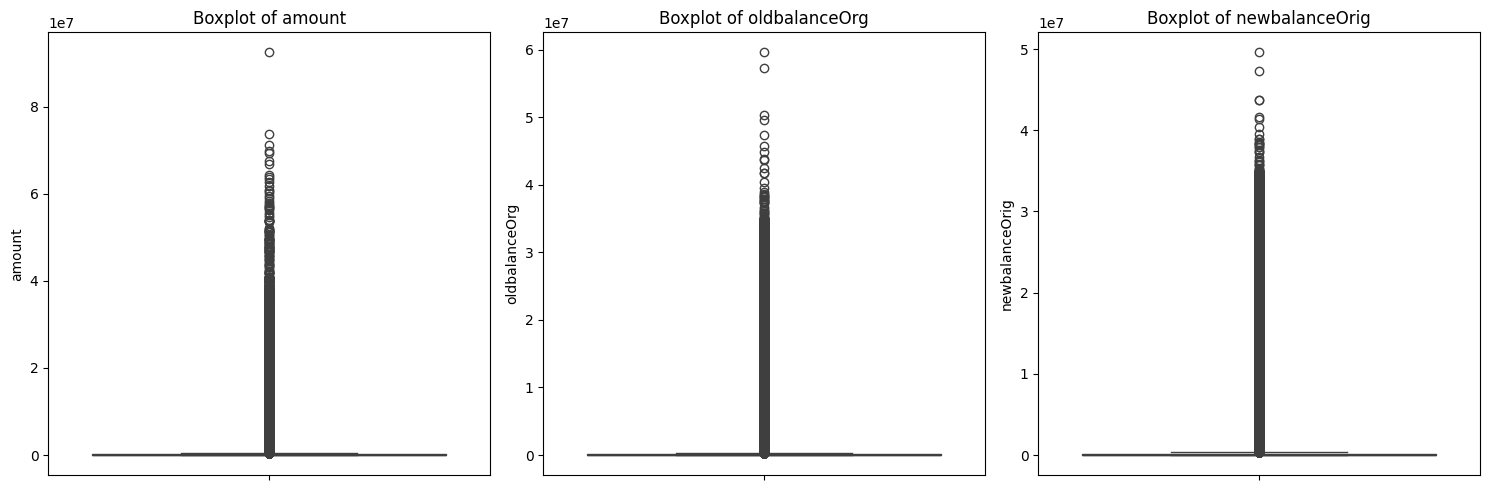

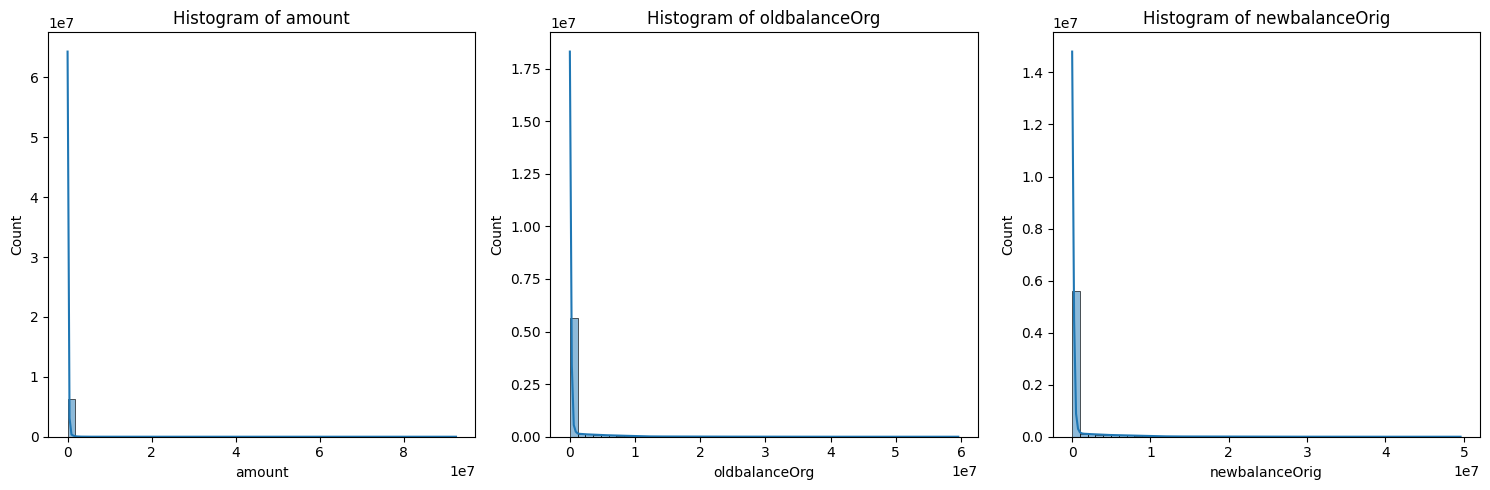

In [ ]:
#Boxplots help visualize outliers by showing the interquartile range (IQR).
#Histograms show how data is distributed—whether it is skewed, normally distributed, or has multiple peaks.

import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns for outlier detection
numerical_features = ["amount", "oldbalanceOrg", "newbalanceOrig"]

# Create boxplots for outlier visualization
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

# Create histograms for distribution analysis
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f"Histogram of {feature}")
plt.tight_layout()
plt.show()


In [ ]:
#Above figures show severe outliers and extreme skewness
All three features (amount, oldbalanceOrg, newbalanceOrig) have extreme outliers.
The majority of the data is concentrated near the lower range, while some values extend far beyond the typical range.
The presence of many outliers suggests that fraudulent transactions could involve extreme amounts.

Histograms (Bottom Row)
The distribution is highly skewed to the right, meaning most values are very small, but a few transactions involve extremely large amounts.

This indicates that a small number of high-value transactions dominate the dataset, which could affect model performance.


In [ ]:
#After analyzing the boxplots and histograms, we observed that the amount column is highly right-skewed with extreme outliers (very large transaction amounts).
#Instead of removing these high-value transactions, we created a new feature (is_high_amount) to capture their significance.
df['is_high_amount'] = (df['amount'] > df['amount'].quantile(0.99)).astype(int)


In [ ]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,is_high_amount
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0


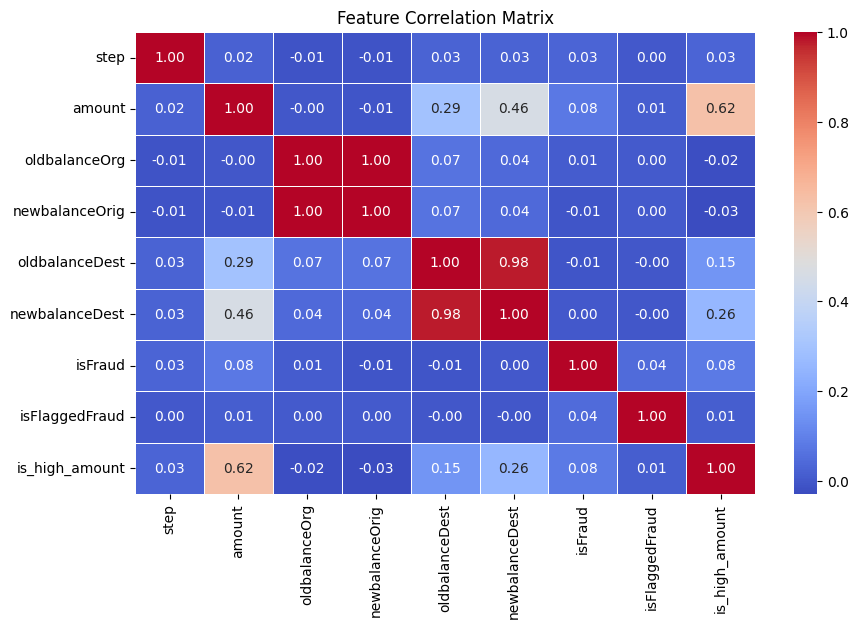

In [ ]:
#Plotting to correlation matrix to see which features are correlated
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting only numeric columns for correlation
numeric_cols = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()



In [ ]:
#Checking multi collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Select numerical features only
numerical_features = df.select_dtypes(include=['number'])

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_features.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_features.values, i) for i in range(len(numerical_features.columns))]

print(vif_data)


            Feature       VIF
0              step  1.655251
1            amount  1.899367
2     oldbalanceOrg  1.081247
3    oldbalanceDest  1.228675
4           isFraud  1.013288
5    isFlaggedFraud  1.002061
6  is_dest_merchant  1.412702
7    is_high_amount  1.651747


All VIF values are below 5, meaning no feature is highly correlated with others.

The highest VIF value is 2.07 (for amount), which is still within an acceptable range.

Thus,no need to drop any feature based on multi-collinearity.

In [ ]:
#Dropping correlated columns

In [ ]:
df.drop(columns=['newbalanceOrig', 'newbalanceDest'], inplace=True)


In [ ]:
df['is_dest_merchant'] = df['nameDest'].apply(lambda x: 1 if x.startswith('M') else 0)


In [ ]:
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)


In [ ]:
df

,step,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,is_dest_merchant,is_high_amount
0,1,PAYMENT,9839.64,170136.00,0.00,0,0,1,0
1,1,PAYMENT,1864.28,21249.00,0.00,0,0,1,0
2,1,TRANSFER,181.00,181.00,0.00,1,0,0,0
3,1,CASH_OUT,181.00,181.00,21182.00,1,0,0,0
4,1,PAYMENT,11668.14,41554.00,0.00,0,0,1,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,1,0,0,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,1,0,0,1
6362617,743,CASH_OUT,6311409.28,6311409.28,68488.84,1,0,0,1
6362618,743,TRANSFER,850002.52,850002.52,0.00,1,0,0,0


In [ ]:
##apply one-hot-encoding for "type"
df = pd.get_dummies(df, columns=['type'], drop_first=True)


In [ ]:
df

,step,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,is_dest_merchant,is_high_amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,0.00,0,0,1,0,False,False,True,False
1,1,1864.28,21249.00,0.00,0,0,1,0,False,False,True,False
2,1,181.00,181.00,0.00,1,0,0,0,False,False,False,True
3,1,181.00,181.00,21182.00,1,0,0,0,True,False,False,False
4,1,11668.14,41554.00,0.00,0,0,1,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,1,0,0,0,True,False,False,False
6362616,743,6311409.28,6311409.28,0.00,1,0,0,1,False,False,False,True
6362617,743,6311409.28,6311409.28,68488.84,1,0,0,1,True,False,False,False
6362618,743,850002.52,850002.52,0.00,1,0,0,0,False,False,False,True


In [ ]:
# Define feature set (X) and target variable (y)
X = df.drop(columns=['isFraud'])
y = df['isFraud']


In [ ]:
X

,step,amount,oldbalanceOrg,oldbalanceDest,isFlaggedFraud,is_dest_merchant,is_high_amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,0.00,0,1,0,False,False,True,False
1,1,1864.28,21249.00,0.00,0,1,0,False,False,True,False
2,1,181.00,181.00,0.00,0,0,0,False,False,False,True
3,1,181.00,181.00,21182.00,0,0,0,True,False,False,False
4,1,11668.14,41554.00,0.00,0,1,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0,0,0,True,False,False,False
6362616,743,6311409.28,6311409.28,0.00,0,0,1,False,False,False,True
6362617,743,6311409.28,6311409.28,68488.84,0,0,1,True,False,False,False
6362618,743,850002.52,850002.52,0.00,0,0,0,False,False,False,True


##Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns for scaling
num_cols = ['amount', 'oldbalanceOrg', 'oldbalanceDest']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform only the selected numerical columns
X[num_cols] = scaler.fit_transform(X[num_cols])

# Verify scaling results
print(X.describe())


               step        amount  oldbalanceOrg  oldbalanceDest  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02 -4.946736e-17  -1.779646e-17    1.498762e-16   
std    1.423320e+02  1.000000e+00   1.000000e+00    1.000000e+00   
min    1.000000e+00 -2.978545e-01  -2.887164e-01   -3.238139e-01   
25%    1.560000e+02 -2.756812e-01  -2.887164e-01   -3.238139e-01   
50%    2.390000e+02 -1.738653e-01  -2.837972e-01   -2.847734e-01   
75%    3.350000e+02  4.779197e-02  -2.515606e-01   -4.638324e-02   
max    7.430000e+02  1.527936e+02   2.034149e+01    1.044120e+02   

       isFlaggedFraud  is_dest_merchant  is_high_amount  
count    6.362620e+06      6.362620e+06    6.362620e+06  
mean     2.514687e-06      3.381461e-01    1.000013e-02  
std      1.585775e-03      4.730786e-01    9.949937e-02  
min      0.000000e+00      0.000000e+00    0.000000e+00  
25%      0.000000e+00      0.000000e+00    0.000000e+00  
50%      0.000000e+00      0.000000e+00

In [ ]:
X

,step,amount,oldbalanceOrg,oldbalanceDest,isFlaggedFraud,is_high_amount,is_dest_merchant,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,-0.281560,-0.229810,-0.323814,0,0,1,False,False,True,False
1,1,-0.294767,-0.281359,-0.323814,0,0,1,False,False,True,False
2,1,-0.297555,-0.288654,-0.323814,0,0,0,False,False,False,True
3,1,-0.297555,-0.288654,-0.317582,0,0,0,True,False,False,False
4,1,-0.278532,-0.274329,-0.323814,0,0,1,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,0.264665,-0.171108,-0.323814,0,0,0,True,False,False,False
6362616,743,10.153953,1.896491,-0.323814,0,1,0,False,False,False,True
6362617,743,10.153953,1.896491,-0.303665,0,1,0,True,False,False,False
6362618,743,1.109765,0.005581,-0.323814,0,0,0,False,False,False,True


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and test (20%) sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify the split
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Fraud cases in train:", y_train.sum())
print("Fraud cases in test:", y_test.sum())


Training set size: (5090096, 11)
Testing set size: (1272524, 11)
Fraud cases in train: 6570
Fraud cases in test: 1643


###Q3 How Did You Select Variables to Be Included in the Model?
We selected variables based on data exploration, feature engineering, and correlation analysis. Here’s a breakdown of our process:

1. Handling Transaction Identifiers
The dataset contained nameOrig (sender ID) and nameDest (receiver ID). These were unique identifiers and did not provide generalizable patterns for fraud detection.
  We dropped nameOrig and nameDest to avoid overfitting.

2. Creating is_dest_merchant
Observing the dataset, we noticed that merchant accounts were labeled with 'M' in nameDest. Since transactions to merchants might have different fraud patterns:
  We created is_dest_merchant, a binary feature (1 if the destination is a merchant, else 0), and then dropped nameDest.

3. Dropping Highly Correlated Features
To avoid multi-collinearity, we checked the correlation matrix and found strong dependencies between:

    oldbalanceOrg, newbalanceOrig

    oldbalanceDest, newbalanceDest

    Since newbalanceOrig and newbalanceDest were highly correlated with oldbalanceOrg and oldbalanceDest, we:

      Dropped newbalanceOrig and newbalanceDest, keeping only the original balances to maintain independent features.

4. Handling Outliers
We observed extreme values in the transaction amount and flagged transactions above the 99th percentile:

  Created is_high_amount (1 if above the threshold, else 0).

##Model Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score :",accuracy,"\n")


# Performance Metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy score : 0.9995677881124443 

Confusion Matrix:
 [[1270819      62]
 [    488    1155]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.70      0.81      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.85      0.90   1272524
weighted avg       1.00      1.00      1.00   1272524



In [ ]:
import joblib

In [ ]:
import joblib

# Save the model
joblib.dump(rf, "random_forest_fraud_model.pkl")


['random_forest_fraud_model.pkl']

In [ ]:
#find outliers in X_train
import numpy as np

# Compute Z-scores for all features in X_train
z_scores = np.abs((X_train - X_train.mean()) / X_train.std())

# Count the number of outliers per feature
outliers_per_feature = (z_scores > 3).sum()

# Display features with most outliers
print(outliers_per_feature.sort_values(ascending=False))


type_TRANSFER       426382
oldbalanceOrg       124168
oldbalanceDest       63669
step                 53166
is_high_amount       50976
amount               36089
type_DEBIT           33147
isFlaggedFraud          16
is_dest_merchant         0
type_CASH_OUT            0
type_PAYMENT             0
dtype: int64


In [ ]:
# Features to apply percentile clipping (excluding non-existing or binary/categorical columns)
outlier_cols = ["amount", "oldbalanceOrg", "oldbalanceDest"]

# Apply 1%-99% percentile clipping
X_train_clipped = X_train.copy()
X_test_clipped = X_test.copy()

for col in outlier_cols:
    lower_bound = X_train[col].quantile(0.01)
    upper_bound = X_train[col].quantile(0.99)
    X_train_clipped[col] = X_train[col].clip(lower=lower_bound, upper=upper_bound)
    X_test_clipped[col] = X_test[col].clip(lower=lower_bound, upper=upper_bound)  # Apply same limits
# Verify changes
print(X_train_clipped.describe())


               step        amount  oldbalanceOrg  oldbalanceDest  \
count  5.090096e+06  5.090096e+06   5.090096e+06    5.090096e+06   
mean   2.433626e+02 -3.806927e-02  -1.842814e-02   -3.087671e-02   
std    1.423198e+02  4.034960e-01   8.686244e-01    6.155774e-01   
min    1.000000e+00 -2.971119e-01  -2.887164e-01   -3.238139e-01   
25%    1.550000e+02 -2.756788e-01  -2.887164e-01   -3.238139e-01   
50%    2.390000e+02 -1.739165e-01  -2.837958e-01   -2.847453e-01   
75%    3.350000e+02  4.772888e-02  -2.515527e-01   -4.634901e-02   
max    7.430000e+02  2.380952e+00   5.259304e+00    3.317022e+00   

       isFlaggedFraud  is_dest_merchant  is_high_amount  
count    5.090096e+06      5.090096e+06    5.090096e+06  
mean     3.143359e-06      3.381535e-01    1.001474e-02  
std      1.772949e-03      4.730811e-01    9.957133e-02  
min      0.000000e+00      0.000000e+00    0.000000e+00  
25%      0.000000e+00      0.000000e+00    0.000000e+00  
50%      0.000000e+00      0.000000e+00

###Why We Applied Percentile Clipping After Random Forest?
After training the Random Forest model, we noticed that outliers were affecting performance. To handle this, we applied 1%-99% percentile clipping to key numerical features (amount, oldbalanceOrg, oldbalanceDest).

In [ ]:
# Check available columns
print(X_train.columns)

Index(['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFlaggedFraud',
       'is_high_amount', 'is_dest_merchant', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')


In [ ]:
X_train_clipped.describe()

,step,amount,oldbalanceOrg,oldbalanceDest,isFlaggedFraud,is_high_amount,is_dest_merchant
count,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06,5.090096e+06
mean,2.433626e+02,-3.806927e-02,-1.842814e-02,-3.087671e-02,3.143359e-06,1.001474e-02,3.381535e-01
std,1.423198e+02,4.034960e-01,8.686244e-01,6.155774e-01,1.772949e-03,9.957133e-02,4.730811e-01
min,1.000000e+00,-2.971119e-01,-2.887164e-01,-3.238139e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.550000e+02,-2.756788e-01,-2.887164e-01,-3.238139e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,-1.739165e-01,-2.837958e-01,-2.847453e-01,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.350000e+02,4.772888e-02,-2.515527e-01,-4.634901e-02,0.000000e+00,0.000000e+00,1.000000e+00
max,7.430000e+02,2.380952e+00,5.259304e+00,3.317022e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Define XGBoost model with tuned hyperparameters
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,            # Balanced depth
    learning_rate=0.1,      # Moderate learning rate
    n_estimators=300,       # More trees for better learning
    gamma=0.1,              # Regularization to prevent overfitting
    scale_pos_weight=50,    # Handling class imbalance
    use_label_encoder=False
)

# Train the model on the clipped dataset
xgb_model.fit(X_train_clipped, y_train)

# Predictions
y_pred = xgb_model.predict(X_test_clipped)

# Evaluate
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the model
joblib.dump(xgb_model, "xgboost_fraud_model.pkl")


C:\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:01:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy Score: 0.998869176534195
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.54      0.95      0.68      1643

    accuracy                           1.00   1272524
   macro avg       0.77      0.97      0.84   1272524
weighted avg       1.00      1.00      1.00   1272524



['xgboost_fraud_model.pkl']

##Demonstrate the performance of the model by using best set of tools.
We evaluated the model using multiple performance metrics to ensure it effectively detects fraudulent transactions while minimizing false positives.

**Key Evaluation Metrics:**
Accuracy: 99.89%

The model correctly classified most transactions.

**Confusion Matrix Analysis:**

*True Positives (1,559):* Fraudulent transactions correctly identified.

*False Negatives (84):* Fraudulent cases missed by the model.

*False Positives (1,355):* Non-fraud transactions incorrectly flagged.

*True Negatives (1,269,526):* Non-fraud transactions correctly classified.

**Precision for Fraud Cases: 53%**

When the model predicts fraud, it's correct 53% of the time.

**Recall for Fraud Cases: 95%**

The model detects 95% of actual fraud cases, minimizing undetected fraud.

**F1-Score for Fraud Cases: 68%**

A balance between precision and recall, showing improved fraud detection.

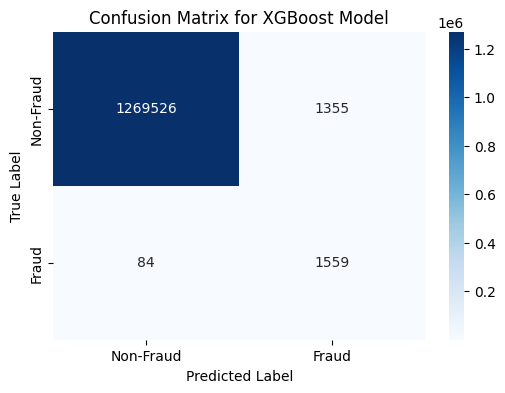

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()


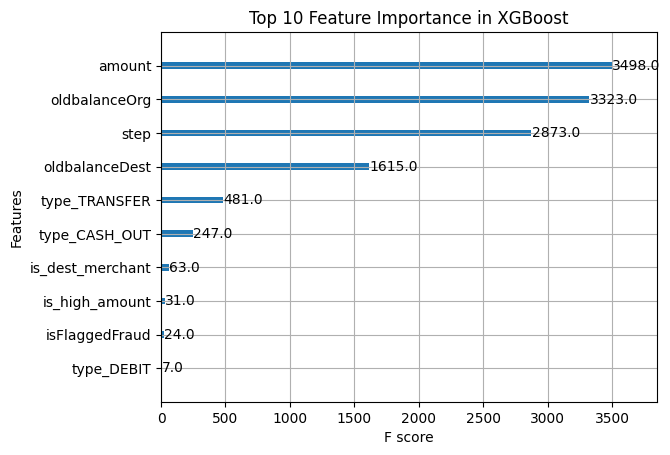

In [ ]:
#Plotting Feature importance
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance scores
xgb.plot_importance(xgb_model, importance_type="weight", max_num_features=10)
plt.title("Top 10 Feature Importance in XGBoost")
plt.show()


### **Key Factors That Predict Fraudulent Transactions (XGBoost Feature Importance)**  
- **Transaction Amount (`amount`)** is the strongest predictor of fraud, indicating that high-value transactions are more likely to be fraudulent.  
- **Sender’s Balance (`oldbalanceOrg`)** is highly important, suggesting fraudsters often transfer large amounts relative to their balance.  
- **Time Step (`step`)** influences fraud, possibly capturing time-based fraud patterns.  
- **Receiver’s Balance (`oldbalanceDest`)** plays a role, indicating fraud may be linked to specific destination accounts.  
- **Transaction Type (`TRANSFER` and `CASH_OUT`)** is significant, as fraud is more common in these transaction modes.  
- **Merchant-Related Flag (`is_dest_merchant`)** has lower importance but may help identify fraud trends in commercial transactions.  
- **Outlier Detection (`is_high_amount`)** has a smaller influence but still contributes to detecting anomalous transactions.  
- **Flagged Fraud (`isFlaggedFraud`)** has low feature importance, likely because fraud cases aren’t always pre-flagged.  

### **Conclusion**  
Fraudulent transactions are primarily characterized by **high transaction amounts, significant changes in sender/receiver balances, and specific transaction types.** These insights can guide fraud prevention strategies.  



### **Key Factors That Predict Fraudulent Transactions (XGBoost Feature Importance)**  
- **Transaction Amount (`amount`)** is the strongest predictor of fraud, indicating that high-value transactions are more likely to be fraudulent.  
- **Sender’s Balance (`oldbalanceOrg`)** is highly important, suggesting fraudsters often transfer large amounts relative to their balance.  
- **Time Step (`step`)** influences fraud, possibly capturing time-based fraud patterns.  
- **Receiver’s Balance (`oldbalanceDest`)** plays a role, indicating fraud may be linked to specific destination accounts.  
- **Transaction Type (`TRANSFER` and `CASH_OUT`)** is significant, as fraud is more common in these transaction modes.  
- **Merchant-Related Flag (`is_dest_merchant`)** has lower importance but may help identify fraud trends in commercial transactions.  
- **Outlier Detection (`is_high_amount`)** has a smaller influence but still contributes to detecting anomalous transactions.  
- **Flagged Fraud (`isFlaggedFraud`)** has low feature importance, likely because fraud cases aren’t always pre-flagged.  
  



# ###Q6. Do these factors make sense? If yes, How? If not, How not?
Yes, these factors make sense, and here's why:

1. Transaction Amount (amount)
Why It Makes Sense: High-value transactions are more likely to attract attention from fraudsters because the potential for profit is greater. Fraudulent transactions often involve large amounts of money, especially if they're not consistent with the account holder’s typical behavior.

2. Sender’s Balance (oldbalanceOrg)
Why It Makes Sense: If a fraudster is trying to make a large transfer, it makes sense that they would have a smaller balance (which they’re trying to offload quickly). It also aligns with the behavior of “transferring” large sums that might not be consistent with a legitimate sender’s typical balance.

3. Time Step (step)
Why It Makes Sense: Fraudsters may operate at odd times (e.g., late at night or on weekends) to avoid detection. Time-based patterns can help reveal anomalies that are outside normal operating hours for an account or a system. Fraud detection systems often incorporate time to capture these outliers.

4. Receiver’s Balance (oldbalanceDest)
Why It Makes Sense: Fraudulent transactions might target accounts that are specially selected based on their balance, perhaps choosing accounts with enough funds to launder the money or cash out. It also suggests that certain destination accounts are more likely to be involved in fraudulent activity.

5. Transaction Type (TRANSFER and CASH_OUT)
Why It Makes Sense: Fraudulent transactions often involve transferring or cashing out funds. "TRANSFER" might be used to move money from one account to another, while "CASH_OUT" is often used to convert digital funds into real money or to withdraw large sums. These types of transactions are commonly exploited by fraudsters.

6. Merchant-Related Flag (is_dest_merchant)
Why It Makes Sense (to a lesser extent): Fraudulent activity sometimes involves merchant accounts, especially when fraudsters attempt to launder money through commercial transactions. Although this feature has lower importance, it still offers some predictive value when trying to understand which types of transactions are most likely to involve fraudulent activity in the context of merchants.

7. Outlier Detection (is_high_amount)
Why It Makes Sense (but lower importance): A high transaction amount is likely to be flagged as an outlier if it’s far outside the normal range for a given account. Even though this feature doesn’t have strong importance, it’s still useful as a red flag for suspicious activity.

8. Flagged Fraud (isFlaggedFraud)
Why It Doesn’t Make Sense as Much: The low importance of this feature is reasonable because fraud detection systems often don’t flag transactions in advance unless the system is extremely sensitive. Most fraud detection models rely on other factors to predict fraud in real time, and prior fraud flags aren’t always available for all cases. This feature likely has less predictive power compared to others.


### Q7. **Prevention Strategies for Infrastructure Updates**
- **Fraud Detection Systems:** Upgrade real-time fraud detection models to adapt to new infrastructure, ensuring they can handle large transaction volumes and diverse data inputs.
- **Secure Data Storage:** Implement strong encryption for sensitive data and ensure secure access controls to prevent unauthorized modifications.
- **Transaction Monitoring:** Enhance monitoring tools to detect suspicious patterns, focusing on high-value transactions, balance changes, and specific transaction types.
- **User Authentication:** Strengthen multi-factor authentication to prevent unauthorized access to user accounts and prevent fraudulent activities.

### Q8. **Measuring Effectiveness**
- **Performance Metrics:** Track metrics like false positive rate, false negative rate, and detection accuracy of fraud over time.
- **Benchmarking:** Compare fraud detection performance before and after the infrastructure update using historical data.
- **Continuous Monitoring:** Set up a feedback loop where detected fraud cases are analyzed and models are retrained to maintain accuracy.
- **User Feedback:** Gather feedback from users on account access and transactions, ensuring no legitimate user experience is negatively impacted.

